# GuessIt Characters Builder (LLM)
In this notebook we'll define the game's characters, their features, render them and analyze the distribution.

Firstly, we'll create the dataset using llm:

In [ ]:
import time
from typing import List, Literal

from langchain_google_genai import ChatGoogleGenerativeAI
import pandas as pd
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field

from dotenv import load_dotenv

# Load variables from .env into the system environment
load_dotenv()


# 1. Schema
class Character(BaseModel):
    name: str = Field(description="First name of the character")
    gender: Literal["Boy", "Girl"] = Field(description="Skin tone")
    skin_tone: Literal["Brown", "White"] = Field(description="Skin tone")
    hair_color: Literal["Black", "Blonde", "Ginger"] = Field(description="Hair color")
    eyes_color: Literal["Brown", "Blue", "Green"] = Field(description="Eyes color")
    expression: Literal["Neutral", "Happy", "Angry"] = Field(description="Facial expression")
    glasses: Literal["None", "Rectangular", "Rounded"] = Field(description="Glasses shape (if any)")
    hat: Literal["None", "Baseball Cap", "Beanie"] = Field(description="Hat type (if any)")


class Roster(BaseModel):
    characters: List[Character]


# 2. Direct Call
# llm = ChatOllama(model="llama3").with_structured_output(Roster)
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0.7).with_structured_output(Roster)

start_time = time.perf_counter()
roster = llm.invoke(
    """
Generate a roster of 24 unique Guess Who characters that strictly follow this visual distribution:
- Gender: A 50/50 split between Boy and Girl (12 each).
- Skin Tone: A 50/50 split between Brown and White (12 each).
- Hair Color: 11 Black, 6 Blonde, and 7 Ginger.
- Eye Color: 12 Brown, 5 Blue, and 9 Green.
- Expression: 12 Neutral, 8 Happy, and 4 Angry.
- Glasses: 12 with None, 6 with Rectangular frames, and 6 with Rounded frames.
- Headwear: 13 with None, 5 wearing Baseball Caps, and 6 wearing Beanies.

Combine the features so it make sense (e.g. try to avoid ginger character with dark skin tone).
Minimize correlation between features.
"""
)
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")
print(f"Average time per character: {total_time / 24:.2f} seconds")

Total time taken: 3.78 seconds
Average time per character: 0.16 seconds


In [ ]:
df = pd.DataFrame([c.model_dump() for c in roster.characters])
display(df)

,name,gender,skin_tone,hair_color,eyes_color,expression,glasses,hat
0,Alice,Girl,White,Blonde,Blue,Happy,None,None
1,Bob,Boy,White,Black,Brown,Neutral,Rectangular,Baseball Cap
2,Charlie,Boy,Brown,Black,Brown,Angry,None,None
3,Diana,Girl,White,Ginger,Green,Neutral,Rounded,Beanie
4,Ethan,Boy,Brown,Black,Green,Happy,None,None
5,Fiona,Girl,White,Blonde,Green,Neutral,Rectangular,None
6,George,Boy,White,Ginger,Blue,Happy,Rounded,None
7,Hannah,Girl,Brown,Black,Brown,Neutral,None,Baseball Cap
8,Ian,Boy,Brown,Black,Brown,Neutral,Rectangular,Beanie
9,Jasmine,Girl,Brown,Black,Green,Happy,None,None


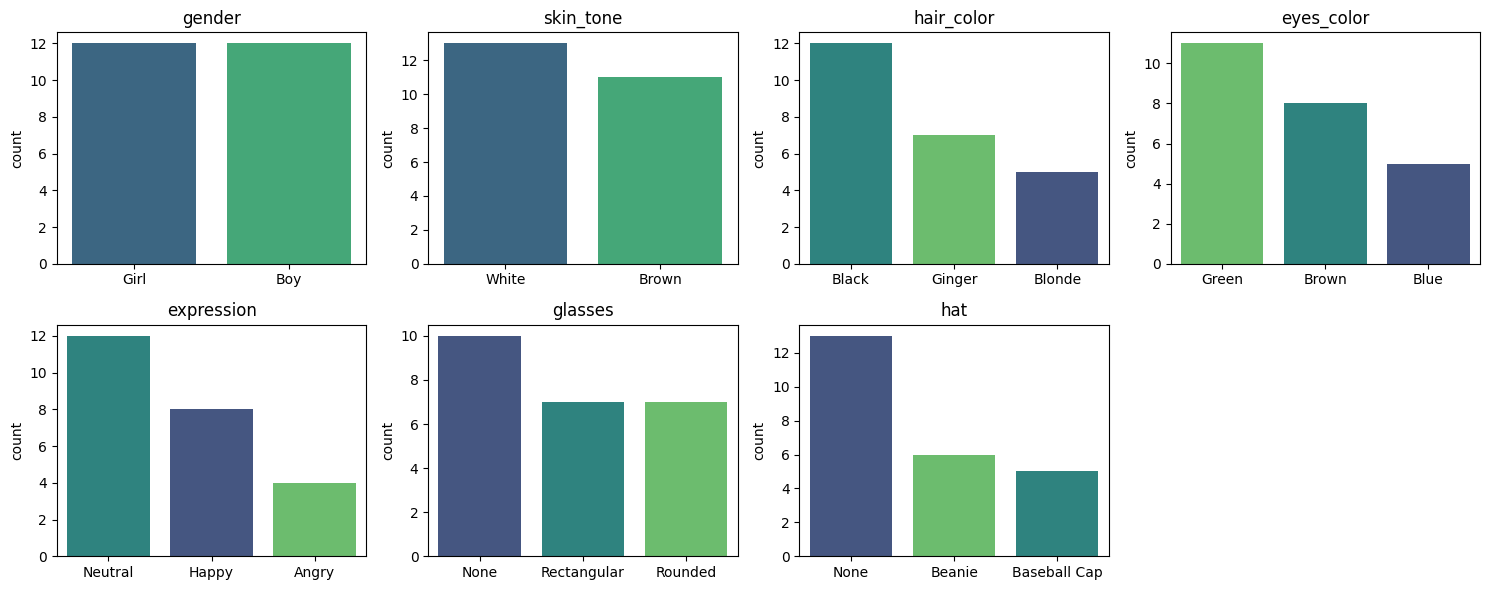

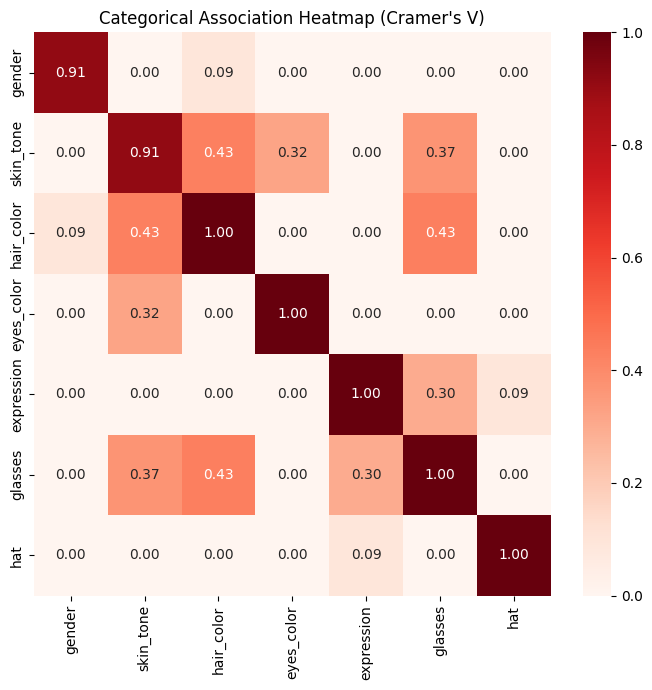

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


# 1. Feature Distribution Plots
def plot_distributions(df):
    # Exclude unique identifiers like 'Name'
    cols_to_plot = [col for col in df.columns if col != "name"]
    n_cols = 4
    n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        # Sort bars by frequency for better readability
        order = df[col].value_counts().index
        sns.countplot(data=df, x=col, ax=axes[i], order=order, palette="viridis", hue=col)
        axes[i].set_title(col)
        axes[i].set_xlabel(None)
        # axes[i].tick_params(axis="x", rotation=45)

    # Remove any extra empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()


# 2. Correlation Matrix (Cramer's V)
def cramers_v(x, y):
    """Calculates Cramer's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Bias correction
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


def plot_correlations(df):
    cols = [col for col in df.columns if col != "name"]
    corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for col1 in cols:
        for col2 in cols:
            corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    plt.figure(figsize=(7, 7))
    sns.heatmap(corr_matrix, annot=True, cmap="Reds", fmt=".2f", vmin=0, vmax=1)
    plt.title("Categorical Association Heatmap (Cramer's V)")
    plt.tight_layout()


plot_distributions(df)
plot_correlations(df)

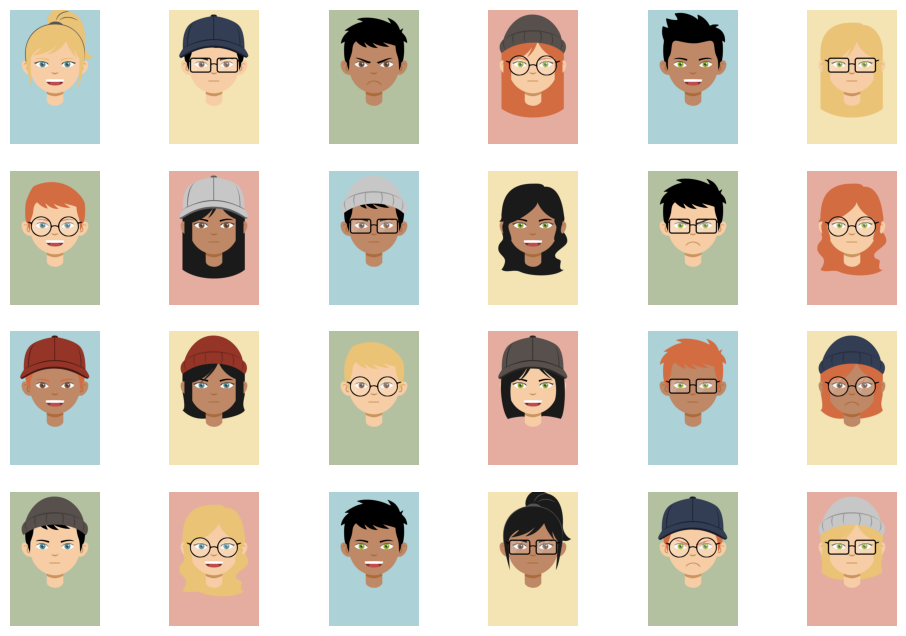

In [ ]:
import itertools
import os
import random

os.environ["PATH"] += os.pathsep + r"C:\Program Files\UniConvertor-2.0rc5\dlls"

import io
import cairosvg
from typing import Any, Dict, Tuple
import matplotlib.pyplot as plt
from PIL import Image


def shuffle(seed: int, items: list) -> list:
    new_list = list(items)
    random.Random(seed).shuffle(new_list)
    return new_list


def get_layer(path, colors: Tuple[str, str] = None, info: Dict[str, Any] = None) -> Image.Image:
    with open(path, "r") as f:
        svg_data = f.read()

    # 1. Modify colors if a map is provided
    if colors:
        svg_data = svg_data.replace(colors[0], colors[1])

    # 2. Convert SVG string to PNG bytes using CairoSVG
    # CairoSVG handles transparency perfectly by default
    png_bytes = cairosvg.svg2png(bytestring=svg_data.encode("utf-8"))
    img = Image.open(io.BytesIO(png_bytes)).convert("RGBA")
    if info:
        img.info |= info
    return img


def create_character(row: pd.Series) -> Image.Image:
    base = Image.new("RGBA", skin[row["skin_tone"]].size, next(BG_COLORS))

    base.alpha_composite(skin[row["skin_tone"]])

    # Add Eyebrows
    if row["expression"] == "Angry":
        base.alpha_composite(eyebrows_angry[row["hair_color"]])
    else:
        base.alpha_composite(eyebrows_neutral[row["hair_color"]])

    # Add Mount
    if row["expression"] == "Neutral":
        base.alpha_composite(mouth_natural)
    if row["expression"] == "Angry":
        base.alpha_composite(mouth_upset)
    if row["expression"] == "Happy":
        base.alpha_composite(mouth_happy)

    # Add Eyes+Hair
    if row["gender"] == "Boy":
        base.alpha_composite(eyes_male[row["eyes_color"]])
        base.alpha_composite(next((i for i in hair_male[row["hair_color"]] if row["hat"] == "None" or i.info["hat_compatiple"])))
    else:
        base.alpha_composite(eyes_female[row["eyes_color"]])
        base.alpha_composite(next((i for i in hair_female[row["hair_color"]] if row["hat"] == "None" or i.info["hat_compatiple"])))

    # Add Glasses
    if row["glasses"] == "Rounded":
        base.alpha_composite(glasses_rounded)
    if row["glasses"] == "Rectangular":
        base.alpha_composite(glasses_rectangular)

    # Add Hat
    if row["hat"] != "None":
        base.alpha_composite(next(hat[row["hat"]]))

    base.info["name"] = row["name"]
    return base


# Load and stack
BG_COLORS = itertools.cycle(["#acd1d7", "#f4e4b3", "#b3c1a0", "#e5ada0"])
BLONDE_COLOR = "#eac376"
GINGER_COLOR = "#d36c41"
EYE_GREEN_COLOR = "#8faf34"
EYE_BLUE_COLOR = "#528f9b"
DARK_SKIN_COLOR = "#bf8867"
HAT_COLOR_WHITE = "#c7c7c7"
HAT_COLOR_RED = "#953528"
HAT_COLOR_GREY = "#57504c"

skin = {"White": get_layer("svgs/skin.svg"), "Brown": get_layer("svgs/skin.svg", ("#f7cda5", DARK_SKIN_COLOR))}
hat = {
    "Baseball Cap": itertools.cycle(
        [
            get_layer("svgs/cap.svg"),
            get_layer("svgs/cap.svg", colors=("#333e54", HAT_COLOR_WHITE)),
            get_layer("svgs/cap.svg", colors=("#333e54", HAT_COLOR_RED)),
            get_layer("svgs/cap.svg", colors=("#333e54", HAT_COLOR_GREY)),
        ]
    ),
    "Beanie": itertools.cycle(
        shuffle(
            24237,
            items=[
                get_layer("svgs/beanie.svg"),
                get_layer("svgs/beanie.svg", colors=("#333e54", HAT_COLOR_WHITE)),
                get_layer("svgs/beanie.svg", colors=("#333e54", HAT_COLOR_RED)),
                get_layer("svgs/beanie.svg", colors=("#333e54", HAT_COLOR_GREY)),
            ],
        )
    ),
}
eyebrows_angry = {
    "Black": get_layer("svgs/eyebrows-angry.svg"),
    "Blonde": get_layer("svgs/eyebrows-angry.svg", colors=("#000000", BLONDE_COLOR)),
    "Ginger": get_layer("svgs/eyebrows-angry.svg", colors=("#000000", GINGER_COLOR)),
}
eyebrows_neutral = {
    "Black": get_layer("svgs/eyebrows-neutral.svg"),
    "Blonde": get_layer("svgs/eyebrows-neutral.svg", colors=("#000000", BLONDE_COLOR)),
    "Ginger": get_layer("svgs/eyebrows-neutral.svg", colors=("#000000", GINGER_COLOR)),
}
eyes_male = {
    "Brown": get_layer("svgs/eyes-male.svg"),
    "Green": get_layer("svgs/eyes-male.svg", colors=("#7a553d", EYE_GREEN_COLOR)),
    "Blue": get_layer("svgs/eyes-male.svg", colors=("#7a553d", EYE_BLUE_COLOR)),
}
eyes_female = {
    "Brown": get_layer("svgs/eyes-female.svg"),
    "Green": get_layer("svgs/eyes-female.svg", colors=("#7a553d", EYE_GREEN_COLOR)),
    "Blue": get_layer("svgs/eyes-female.svg", colors=("#7a553d", EYE_BLUE_COLOR)),
}
glasses_rectangular = get_layer("svgs/glasses-rectangular.svg")
glasses_rounded = get_layer("svgs/glasses-rounded.svg")
hair_female = {
    "Black": itertools.cycle([get_layer(f"svgs/hair-female-v{i+1}.svg", info={"hat_compatiple": i > 0}) for i in range(5)]),
    "Blonde": itertools.cycle(
        [get_layer(f"svgs/hair-female-v{i+1}.svg", info={"hat_compatiple": i > 0}, colors=("#1a1a1a", BLONDE_COLOR)) for i in range(5)]
    ),
    "Ginger": itertools.cycle(
        [get_layer(f"svgs/hair-female-v{i+1}.svg", info={"hat_compatiple": i > 0}, colors=("#1a1a1a", GINGER_COLOR)) for i in range(5)]
    ),
}
hair_male = {
    "Black": itertools.cycle([get_layer(f"svgs/hair-male-v{i+1}.svg", info={"hat_compatiple": i == 0}) for i in range(4)]),
    "Blonde": itertools.cycle(
        [get_layer(f"svgs/hair-male-v{i+1}.svg", info={"hat_compatiple": i == 0}, colors=("#000000", BLONDE_COLOR)) for i in range(4)]
    ),
    "Ginger": itertools.cycle(
        [get_layer(f"svgs/hair-male-v{i+1}.svg", info={"hat_compatiple": i == 0}, colors=("#000000", GINGER_COLOR)) for i in range(4)]
    ),
}
mouth_happy = get_layer("svgs/mouth-happy.svg")
mouth_natural = get_layer("svgs/mouth-natural.svg")
mouth_upset = get_layer("svgs/mouth-upset.svg")


# fig, ax = plt.subplots(figsize=(4, 6))
# ax.imshow(create_character(data.iloc[1]))
# ax.axis("off")

fig, axes = plt.subplots(4, 6, figsize=(12, 8))
fig.canvas.manager.set_window_title("Avatar Gallery")

final_images = []
for i, ax in enumerate(axes.flat):
    img = create_character(df.iloc[i])
    final_images.append(img)
    ax.imshow(img)
    ax.axis("off")

In [ ]:
for i,img in enumerate(final_images):
    img.save(f"output/{i+1}_{img.info["name"]}.png")